In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# CARGA DE DATOS
file_path = '/content/olist_united_dataset.csv'
df = pd.read_csv(file_path)

/tmp/ipython-input-2749187127.py:3: DtypeWarning: Columns (16,17,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [26]:
# CALCULO DE TIEMPO DE ENTREGA ESTIMADA
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_estimated_delivery_date']=pd.to_datetime(df['order_estimated_delivery_date'])
df['calc_delivery_time']=df['order_estimated_delivery_date']-df['order_purchase_timestamp']
# convertir a int en horas
df['calc_delivery_time'] = (df['calc_delivery_time'] / pd.Timedelta(hours=1)).astype('int64')

In [27]:
# 2. SELECCIÓN DE COLUMNAS (Solo las que tú indicaste)
cols_to_keep = [
    'order_status',
    'price',
    'freight_value',
    'payment_sequential',
    'payment_type',
    'payment_installments',
    'payment_value',
    'review_score',
    'product_category_name',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm',
    'calc_delivery_time'
]

In [28]:
df_clean = df[cols_to_keep].copy()

In [29]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50649 entries, 0 to 50648
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_status           50649 non-null  object 
 1   price                  50649 non-null  float64
 2   freight_value          50649 non-null  float64
 3   payment_sequential     50649 non-null  int64  
 4   payment_type           50649 non-null  object 
 5   payment_installments   50648 non-null  object 
 6   payment_value          50648 non-null  object 
 7   review_score           50648 non-null  float64
 8   product_category_name  49911 non-null  object 
 9   product_weight_g       50636 non-null  float64
 10  product_length_cm      50636 non-null  float64
 11  product_height_cm      50636 non-null  float64
 12  product_width_cm       50636 non-null  float64
 13  calc_delivery_time     50649 non-null  int64  
dtypes: float64(7), int64(2), object(5)
memory usage: 5.4+ 

## Análisis Chi Cuadrado para variables categoricas


*   P-Value < 0.05. La variable influye
*   P-Value >= 0.05. La variable no inluye



In [42]:
from scipy.stats import chi2_contingency

In [43]:
# TARGET
categorical_features = ['order_status', 'payment_type', 'product_category_name']
target = 'review_score'
results = []

In [45]:
for col in categorical_features:
    # Crear Tabla de Contingencia (Crosstab)
    contingency_table = pd.crosstab(df_clean[col], df_clean[target])

    # Calcular Chi-cuadrado
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Interpretación básica
    dependence = "Dependiente (Influye)" if p_value < 0.05 else "Independiente (No influye)"

    results.append({
        'Variable': col,
        'Chi2 Stat': chi2,
        'P-Value': p_value,
        'Resultado': dependence
    })


In [47]:
chi2_df = pd.DataFrame(results).sort_values(by='Chi2 Stat', ascending=False)
print("\n\nRESUMEN GENERAL:")
print(chi2_df)



RESUMEN GENERAL:
                Variable     Chi2 Stat  P-Value              Resultado
5  product_category_name  51709.451571      0.0  Dependiente (Influye)
2  product_category_name  51709.451571      0.0  Dependiente (Influye)
4           payment_type  50685.153299      0.0  Dependiente (Influye)
1           payment_type  50685.153299      0.0  Dependiente (Influye)
0           order_status   3553.842813      0.0  Dependiente (Influye)
3           order_status   3553.842813      0.0  Dependiente (Influye)


/tmp/ipython-input-4234735707.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Chi2 Stat', y='Variable', data=chi2_df, palette='magma')


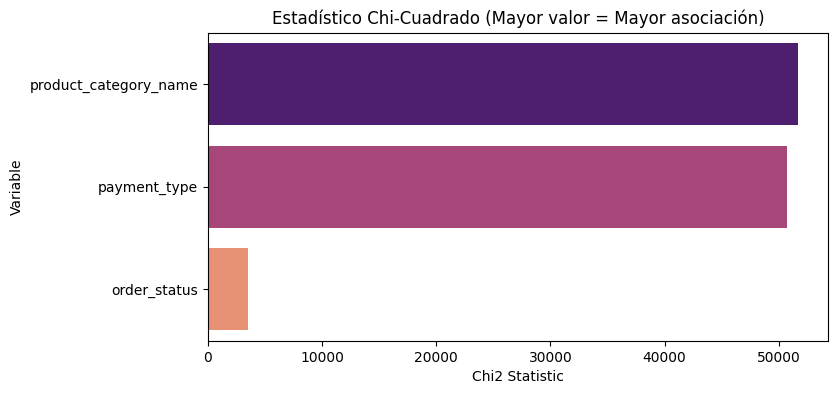

In [48]:
# Visualización del P-Value (opcional)
plt.figure(figsize=(8, 4))
sns.barplot(x='Chi2 Stat', y='Variable', data=chi2_df, palette='magma')
plt.title('Estadístico Chi-Cuadrado (Mayor valor = Mayor asociación)')
plt.xlabel('Chi2 Statistic')
plt.show()

## Correlación

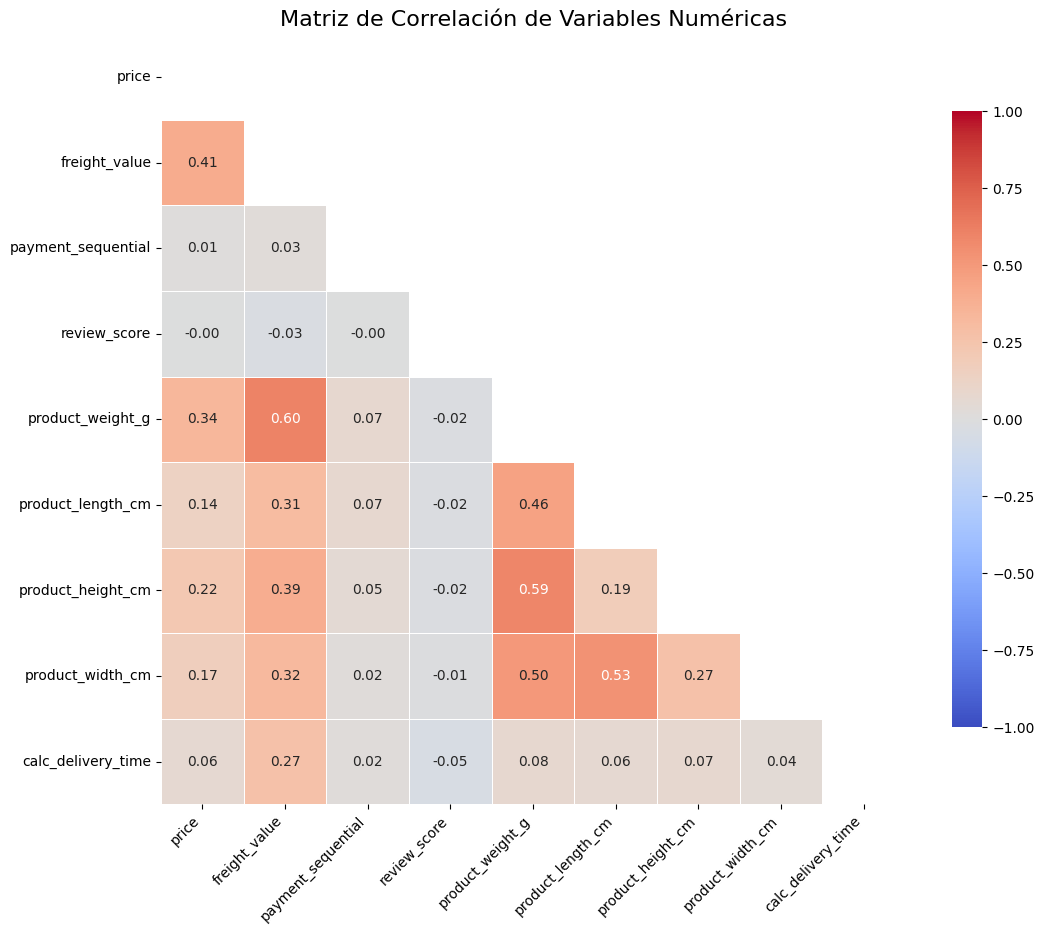

In [41]:
numerical_df = df_clean.select_dtypes(include=['number'])
corr_matrix = numerical_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# GRAFICO
plt.figure(figsize=(12, 10))
plt.title('Matriz de Correlación de Variables Numéricas', fontsize=16)

sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            vmax=1, vmin=-1,
            center=0,
            linewidths=.5,
            cbar_kws={"shrink": .8}
           )

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

## Métodos integrados con RandomForest

In [30]:
# DEFINIMOS COLUMNA A PREDECIR (Y)
TARGET_COL = 'review_score'

In [31]:
# PREPROCESAMIENTO
# DIFERENCIACION DE TIPO DE VARIABLES
cat_cols = df_clean.select_dtypes(include=['object']).columns
num_cols = df_clean.select_dtypes(include=['number']).columns

In [32]:
# PREPROCESAMIENTO
# CATEGORICAS SE LLENAN LOS VACIOS CON DATOS 'DESCONOCIDO'
# NUMERICAS SE LLENAN CON LA MEDIA
cols_to_fill_num = [c for c in num_cols if c != TARGET_COL]

for col in cat_cols:
    df_clean[col] = df_clean[col].fillna("Desconocido")

for col in cols_to_fill_num:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

df_clean = df_clean.dropna(subset=[TARGET_COL])

In [33]:
# DEFINICION DE X e Y
X = df_clean.drop(TARGET_COL, axis=1)
y = df_clean[TARGET_COL]

In [34]:
# CODIFICAR LAS VARIABLES CATEGORICAS
cat_cols_X = X.select_dtypes(include=['object']).columns
if len(cat_cols_X) > 0:
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols_X] = X[cat_cols_X].astype(str)
    X[cat_cols_X] = encoder.fit_transform(X[cat_cols_X])

In [35]:
# ENTRENAMIENTO (80,20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Detectar si es Clasificación (pocas clases) o Regresión (muchos valores continuos)
if y.nunique() <= 10 or y.dtype == 'object':
    # Clasificación
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
else:
    # Regresión
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print("Entrenando...")

Entrenando...


In [36]:
# RESULTADOS
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)


/tmp/ipython-input-3277755411.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


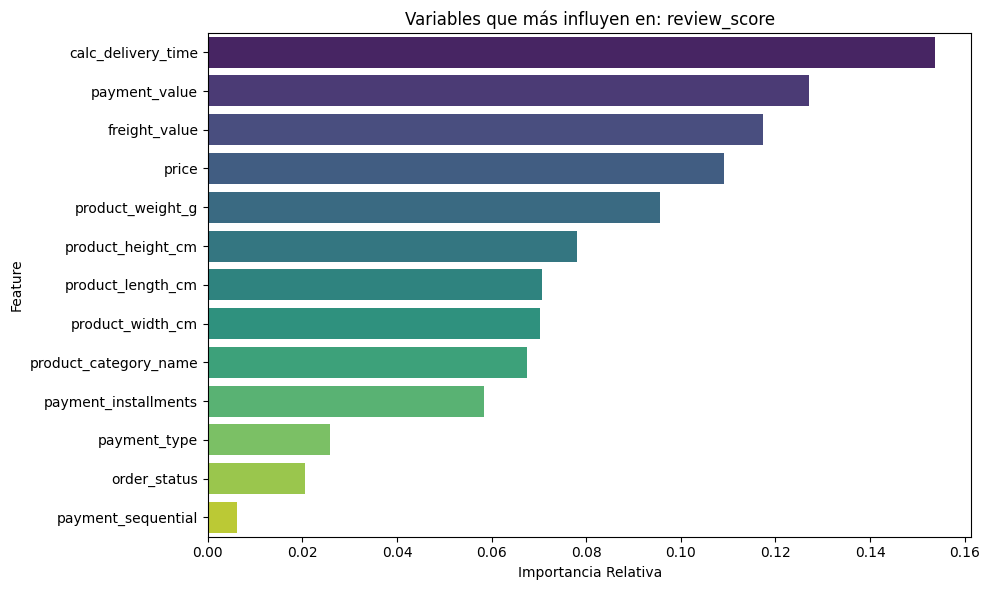

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title(f'Variables que más influyen en: {TARGET_COL}')
plt.xlabel('Importancia Relativa')
plt.tight_layout()
plt.show()

In [39]:
print(feature_importances)

                  Feature  Importance
12     calc_delivery_time    0.153734
6           payment_value    0.127002
2           freight_value    0.117355
1                   price    0.109083
8        product_weight_g    0.095583
10      product_height_cm    0.078089
9       product_length_cm    0.070648
11       product_width_cm    0.070271
7   product_category_name    0.067427
5    payment_installments    0.058336
4            payment_type    0.025815
0            order_status    0.020455
3      payment_sequential    0.006203
